# MNIST-Adder

**Task:** For the MNIST data set, device a network, which takes two images as input and which outputs the image of the sum of the numbers on two input images.

## DeepProbLog

https://github.com/ML-KULeuven/deepproblog

```
@article{DBLP:journals/corr/abs-1805-10872,
  author    = {Robin Manhaeve and
               Sebastijan Dumancic and
               Angelika Kimmig and
               Thomas Demeester and
               Luc De Raedt},
  title     = {DeepProbLog: Neural Probabilistic Logic Programming},
  journal   = {CoRR},
  volume    = {abs/1805.10872},
  year      = {2018},
  url       = {http://arxiv.org/abs/1805.10872},
  eprinttype = {arXiv},
  eprint    = {1805.10872},
  timestamp = {Mon, 13 Aug 2018 16:46:18 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1805-10872.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
```

### Setup

Note: Requires runtime restart after installations

In [1]:
!pip install problog pysdd
# pyswip
!git clone https://github.com/ML-KULeuven/pyswip.git
%cd pyswip
!sudo python setup.py -q install
%cd ..
# deepproblog
!git clone https://github.com/ML-KULeuven/deepproblog.git
%cd deepproblog/
!sudo python setup.py -q install
%cd ..
# swi-prolog
!sudo apt-add-repository -y ppa:swi-prolog/stable > /dev/null 2>&1
!sudo apt-get -qq install swi-prolog

     |████████████████████████████████| 941 kB 7.7 MB/s 
     |████████████████████████████████| 3.5 MB 39.8 MB/s 
  Created wheel for problog: filename=problog-2.2.2-py3-none-any.whl size=1220796 sha256=dfb9c8389dac1cd9a4cb16e83dd05b0dc82564b5fe7cb8713c2feb2b98b2bb1e
  Stored in directory: /root/.cache/pip/wheels/40/91/9e/412180b9c1c11f560feb467dbb0455d15877ec35abbd2228e5
  Created wheel for pysdd: filename=PySDD-0.2.10-cp37-cp37m-linux_x86_64.whl size=2322635 sha256=e3b9167aacedc5228a9107eb7e00a635979dbfe9b53c1802a0be08ddf76014c5
  Stored in directory: /root/.cache/pip/wheels/4f/d0/30/f01a26723750159dae4b464a9b9ca45e2aea4941f90f6fc394
Successfully built problog pysdd
Cloning into 'pyswip'...
remote: Enumerating objects: 1317, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 1317 (delta 163), reused 204 (delta 122), pack-reused 1052
Receiving objects: 100% (1317/1317), 359.66 KiB | 14.39 MiB/s, done.
Resolving delta

In [1]:
# pretrain a simple cnn digit classifier on the MNIST dataset
# https://github.com/ML-KULeuven/deepproblog/blob/master/src/deepproblog/examples/MNIST/models/pretrained/create_pretrained.py
# https://github.com/ML-KULeuven/deepproblog/blob/master/src/deepproblog/examples/MNIST/network.py
%cd /content/deepproblog/src/deepproblog/examples/MNIST/models/pretrained
!python create_pretrained.py

/content/deepproblog/src/deepproblog/examples/MNIST/models/pretrained
9913344it [00:01, 6766020.63it/s]                 
Extracting /usr/local/lib/python3.7/dist-packages/deepproblog-2.0.0-py3.7.egg/deepproblog/examples/MNIST/data/MNIST/raw/train-images-idx3-ubyte.gz to /usr/local/lib/python3.7/dist-packages/deepproblog-2.0.0-py3.7.egg/deepproblog/examples/MNIST/data/MNIST/raw

29696it [00:00, 55679057.48it/s]
Extracting /usr/local/lib/python3.7/dist-packages/deepproblog-2.0.0-py3.7.egg/deepproblog/examples/MNIST/data/MNIST/raw/train-labels-idx1-ubyte.gz to /usr/local/lib/python3.7/dist-packages/deepproblog-2.0.0-py3.7.egg/deepproblog/examples/MNIST/data/MNIST/raw

1649664it [00:00, 8758094.35it/s]                
Extracting /usr/local/lib/python3.7/dist-packages/deepproblog-2.0.0-py3.7.egg/deepproblog/examples/MNIST/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /usr/local/lib/python3.7/dist-packages/deepproblog-2.0.0-py3.7.egg/deepproblog/examples/MNIST/data/MNIST/raw

5120it [00:00, 23

In [2]:
!ls
!cat accuracies.txt
%cd /content

accuracies.txt	all_16.pth   all_32.pth  all_8.pth
all_128.pth	all_256.pth  all_64.pth  create_pretrained.py
('all', 8)	0.3625
('all', 16)	0.5971
('all', 32)	0.5301
('all', 64)	0.676
('all', 128)	0.7682
('all', 256)	0.8931
/content


In [3]:
# after installations, runtime needs to be restarded before running the following cells

# https://github.com/ML-KULeuven/deepproblog/blob/master/src/deepproblog/examples/MNIST/addition.py
import sys
from json import dumps

import numpy as np
import torch

from tqdm import tqdm

from deepproblog.dataset import DataLoader
from deepproblog.engines import ApproximateEngine, ExactEngine
from deepproblog.evaluate import get_confusion_matrix
from deepproblog.examples.MNIST.network import MNIST_Net
from deepproblog.examples.MNIST.data import (
    MNIST_train,
    MNIST_test,
    addition,
)
from deepproblog.heuristics import geometric_mean
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.train import train_model
from deepproblog.utils import get_configuration, format_time_precise, config_to_string

In [4]:
parameters = {
    "method": ["gm", "exact"],  # approximate vs exact problog engine
    "N": [1, 2, 3],  # number of digits
    "pretrain": [0],  # pretrained model
    "exploration": [False, True],  # exploration in engine
    "run": range(5),  # seed
}
configuration = get_configuration(parameters, 0)
configuration = {
    "method": "gm",
    "N": 1,
    "pretrain": 256,
    "exploration": False,
    "run": 0,
}

In [5]:
# data
train_set = addition(configuration["N"], "train")
test_set = addition(configuration["N"], "test")

loader = DataLoader(train_set, 2, False)
len(train_set), len(test_set)

(30000, 5000)

In [6]:
import matplotlib.pyplot as plt

def plot_example(dataset, idx):
    is_multi_add = len(dataset[0][0]) > 1
    if is_multi_add:
        if len(dataset[0][0]) == 3:
            figsize = (16, 16)
        else:
            figsize = (12, 12)
    else:
        figsize = None
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i in range(2):
        if is_multi_add:
            ax[i].imshow(np.concatenate(np.array([t.squeeze().numpy() for t in dataset[idx][i]]), axis=1))
        else:
            ax[i].imshow(dataset[idx][i][0].squeeze())
    plt.show()
    print(f"index: {idx}")
    print(f"query: {dataset.to_query(idx).variable_output()}")
    print(f"label: {dataset[idx][2]}")

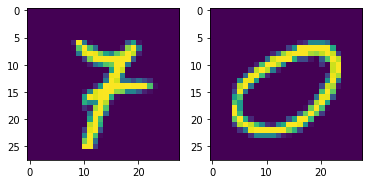

index: 4124
query: (1.0::addition(p0_0,p1_0,X_2), {p0_0: tensor(train(8248)), p1_0: tensor(train(8249))})
label: 7



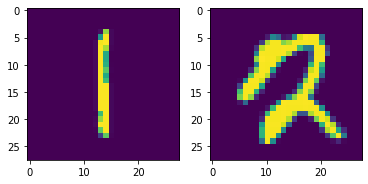

index: 26509
query: (1.0::addition(p0_0,p1_0,X_2), {p0_0: tensor(train(53018)), p1_0: tensor(train(53019))})
label: 3



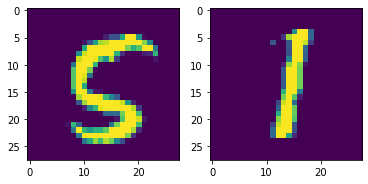

index: 20460
query: (1.0::addition(p0_0,p1_0,X_2), {p0_0: tensor(train(40920)), p1_0: tensor(train(40921))})
label: 6



In [162]:
for i in np.random.choice(np.arange(len(train_set)), 3):
    plot_example(train_set, i)
    print()

In [8]:
torch.manual_seed(configuration["run"])
name = "addition_" + config_to_string(configuration) + "_" + format_time_precise()

In [9]:
# load pretrained classifier
network = MNIST_Net()
pretrain = configuration["pretrain"]
if pretrain is not None and pretrain > 0:
    network.load_state_dict(
        torch.load("deepproblog/src/deepproblog/examples/MNIST/models/pretrained/all_{}.pth".format(configuration["pretrain"]))
    )
net = Network(network, "mnist_net", batching=True)
net.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

In [10]:
# (Deep)Problog Model:
# https://github.com/ML-KULeuven/deepproblog/blob/master/src/deepproblog/examples/MNIST/models/addition.pl

model = Model("deepproblog/src/deepproblog/examples/MNIST/models/addition.pl", [net])
model.set_engine(
    ApproximateEngine(
        model, 1, geometric_mean, exploration=configuration["exploration"]
    )
)
model.add_tensor_source("train", MNIST_train)
model.add_tensor_source("test", MNIST_test)

In [11]:
# Fine tune the pretrained model together with the logical units on the addition task
train = train_model(model, loader, 1, log_iter=1000, profile=0)

Training  for 1 epoch(s)
Epoch 1
Iteration:  1000 	s:95.3538 	Average Loss:  0.5378574487756123
Iteration:  2000 	s:95.1469 	Average Loss:  0.37964836052847406
Iteration:  3000 	s:96.2098 	Average Loss:  0.2909588285889798
Iteration:  4000 	s:94.7476 	Average Loss:  0.26683791468798596
Iteration:  5000 	s:95.0558 	Average Loss:  0.22902923063781075
Iteration:  6000 	s:95.0029 	Average Loss:  0.19325035340297836
Iteration:  7000 	s:94.8111 	Average Loss:  0.21866062860908048
Iteration:  8000 	s:94.7606 	Average Loss:  0.22290360117887356
Iteration:  9000 	s:94.7750 	Average Loss:  0.17441981698368916
Iteration:  10000 	s:94.4890 	Average Loss:  0.20950676965603426
Iteration:  11000 	s:94.6731 	Average Loss:  0.1985216578420393
Iteration:  12000 	s:94.4928 	Average Loss:  0.18476769020133932
Iteration:  13000 	s:94.5085 	Average Loss:  0.17847147575526645
Iteration:  14000 	s:94.5823 	Average Loss:  0.18152906078228512
Iteration:  15000 	s:94.4698 	Average Loss:  0.11634779708693992
Epoc

In [12]:
# save
model.save_state("snapshot/" + name + ".pth")
train.logger.comment(dumps(model.get_hyperparameters()))

In [13]:
!ls snapshot

addition_method_gm_N_1_pretrain_256_exploration_False_run_0_220401_144344265391.pth


In [14]:
model.load_state("snapshot/addition_method_gm_N_1_pretrain_256_exploration_False_run_0_220401_144344265391.pth")

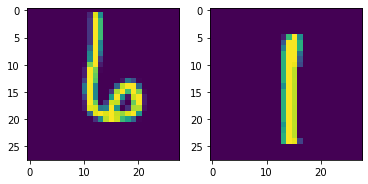

index: 2958
query: (1.0::addition(p0_0,p1_0,X_2), {p0_0: tensor(test(5916)), p1_0: tensor(test(5917))})
label: 7
prediction: 7 



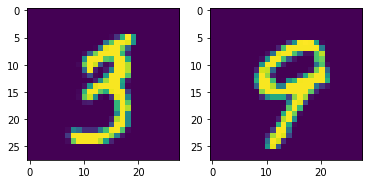

index: 4476
query: (1.0::addition(p0_0,p1_0,X_2), {p0_0: tensor(test(8952)), p1_0: tensor(test(8953))})
label: 12
prediction: 12 



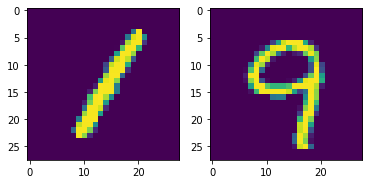

index: 910
query: (1.0::addition(p0_0,p1_0,X_2), {p0_0: tensor(test(1820)), p1_0: tensor(test(1821))})
label: 10
prediction: 10 



In [163]:
# evaluation
model.eval()
test_queries = [q.variable_output() for q in test_set.to_queries()]

# plot test examples
for i in np.random.choice(np.arange(len(test_set)), 3):
    plot_example(test_set, i)
    print("prediction:", max(model.solve([test_queries[i]])[0].result).args[-1], "\n")

In [16]:
# compute accuracy
batch_size = 8
query_batches = [test_queries[i:i+batch_size] for i in range(0, len(test_queries), batch_size)]
pred = []
for i, batch in enumerate(tqdm(query_batches)):
    pred.append([max(p.result).args[-1] for p in model.solve(batch)])
pred = np.array(pred).flatten()
true = np.array([t[2] for t in test_set])
print("Accuracy:", sum(true == pred) / len(true))

100%|██████████| 625/625 [03:58<00:00,  2.62it/s]


Accuracy: 0.9562


## Conditional-GAN

In [17]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch

In [18]:
# config
latent_dim = 100
batch_size = 64
img_shape = (1, 28, 28)
lr = 0.0002
n_epochs = 100
n_classes = 10
embedding_dim = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
b1 = 0.5
b2 = 0.999

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_embedding = nn.Sequential(
            nn.Embedding(n_classes, embedding_dim),
            nn.Linear(embedding_dim, 7*7)
        )
        self.latent = nn.Sequential(
            nn.Linear(latent_dim, 7*7*64),
            nn.ReLU(inplace=True)
        )

        self.model = nn.Sequential(
            nn.ConvTranspose2d(64+1, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # reshape and concatenate noise and label embedding
        noise = self.latent(noise).view(labels.shape[0], 64, 7, 7)
        label_emb = self.label_embedding(labels).view(labels.shape[0], 1, 7, 7)
        gen_input = torch.cat((noise, label_emb), dim=1)
        # generate image
        img = self.model(gen_input)
        img = img.view(labels.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Sequential(
            nn.Embedding(n_classes, embedding_dim),
            nn.Linear(embedding_dim, int(np.prod(img_shape)))
        )

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # concatenate image and label
        label_emb = self.label_embedding(labels).view(img.shape[0], *img_shape)
        d_in = torch.cat((img, label_emb), dim=1)
        # predict validity
        validity = self.model(d_in)
        return validity

In [20]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [21]:
from torchvision import datasets, transforms

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "/tmp",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

Train progress:   0%|          | 0/100 [00:15<?, ?it/s, g-loss=3.35, d-loss=0.314]

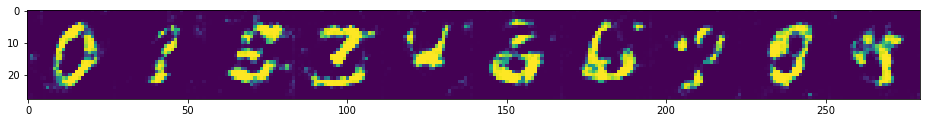

Train progress:  10%|█         | 10/100 [02:39<21:38, 14.43s/it, g-loss=2.47, d-loss=0.252]

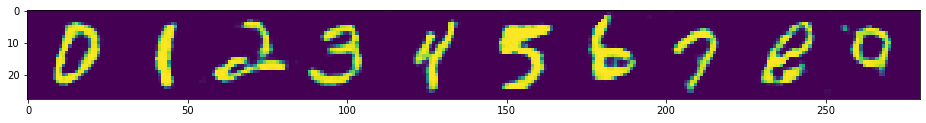

Train progress:  20%|██        | 20/100 [05:04<19:20, 14.50s/it, g-loss=1.54, d-loss=0.525]

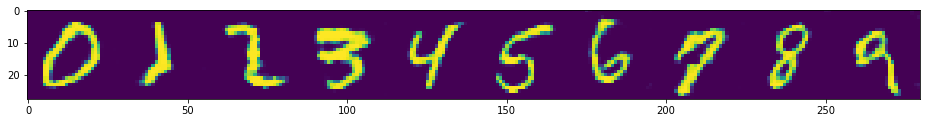

Train progress:  30%|███       | 30/100 [07:29<16:49, 14.43s/it, g-loss=2.82, d-loss=0.324] 

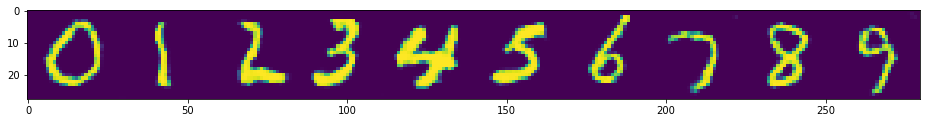

Train progress:  40%|████      | 40/100 [09:54<14:27, 14.46s/it, g-loss=2.48, d-loss=0.39]

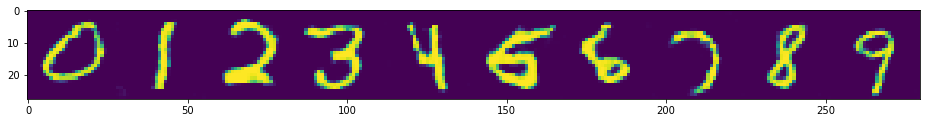

Train progress:  50%|█████     | 50/100 [12:18<12:00, 14.40s/it, g-loss=3.88, d-loss=0.18]

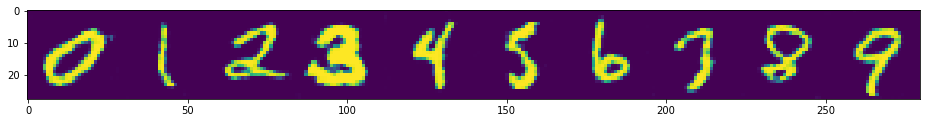

Train progress:  60%|██████    | 60/100 [14:43<09:38, 14.47s/it, g-loss=4.53, d-loss=0.0622]

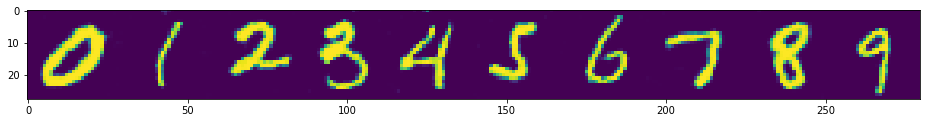

Train progress:  70%|███████   | 70/100 [17:09<07:15, 14.53s/it, g-loss=5.7, d-loss=0.0885]

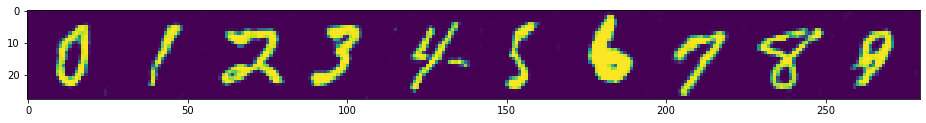

Train progress:  80%|████████  | 80/100 [19:33<04:48, 14.41s/it, g-loss=4.68, d-loss=0.179]

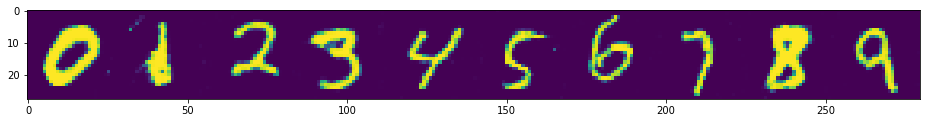

Train progress:  90%|█████████ | 90/100 [21:57<02:24, 14.45s/it, g-loss=2.64, d-loss=0.13] 

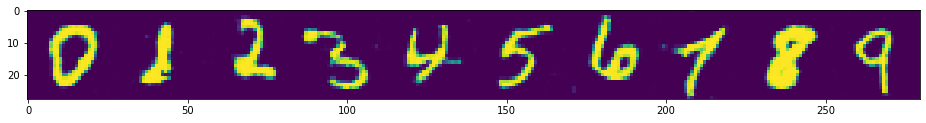

Train progress: 100%|██████████| 100/100 [24:08<00:00, 14.49s/it, g-loss=5.79, d-loss=0.0714]


In [23]:
d_losses, g_losses = [], []
pbar = tqdm.tqdm(range(n_epochs), desc="Train progress", file=sys.stdout)
for epoch in pbar:
    for i, (imgs, labels) in enumerate(dataloader):
        iter_bs = imgs.shape[0]

        real_imgs = imgs.to(device)
        real_labels = labels.to(device).unsqueeze(1)

        # adversarial ground truth
        valid = torch.ones(iter_bs, 1, requires_grad=False, device=device)
        fake = torch.zeros(iter_bs, 1, requires_grad=False, device=device)

        # train generator
        g_optimizer.zero_grad()
        # sample noise and labels
        z = torch.randn(iter_bs, latent_dim, device=device)
        gen_labels = torch.randint(0, n_classes, size=(iter_bs, 1), device=device)
        # generate images
        gen_imgs = generator(z, gen_labels)
        # generator loss
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        g_optimizer.step()

        # train discriminator
        d_optimizer.zero_grad()
        # loss for real images
        validity_real = discriminator(real_imgs, real_labels)
        d_real_loss = adversarial_loss(validity_real, valid)
        # loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)
        # total loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    pbar.set_postfix({"g-loss": g_losses[-1], "d-loss": d_losses[-1]})

    if epoch%10 == 0:
        with torch.no_grad():
            z = torch.randn(n_classes, latent_dim, device=device)
            labels = torch.arange(0, n_classes, dtype=int, device=device).reshape(n_classes, 1)
            gen_imgs = generator(z, labels)
            plt.figure(figsize=(16, 16))
            plt.imshow(np.concatenate(gen_imgs.squeeze().cpu().detach().numpy(), axis=1))
            plt.show()

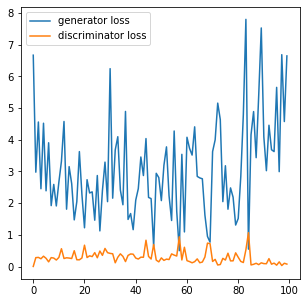

In [24]:
plt.figure(figsize=(5, 5))
plt.plot(g_losses[::len(dataloader)], label="generator loss")
plt.plot(d_losses[::len(dataloader)], label="discriminator loss")
plt.legend()
plt.show()

## Combine Models

In [137]:
class MNISTAdder:
    def __init__(self, addition_model, generator):
        self.addition_model = addition_model
        self.generator = generator

        #self.addition_model.eval()
        #self.generator.eval()

    def add(self, dataset, idx, plot=True):
        with torch.no_grad():
            query = dataset.to_query(idx)
            pred_sum = max(self.addition_model.solve([query])[0].result).args[-1]
            pred_sum = torch.tensor(list(map(int, list(str(pred_sum)))), device=device)
            z = torch.randn(len(pred_sum), latent_dim, device=device)
            img = generator(z, pred_sum)
            if plot:
                plt.figure(figsize=(16, 16))
                fig, ax = plt.subplots(1, 3)
                ax[0].imshow(torch.cat(dataset[idx][0], axis=-1).squeeze().cpu().detach().numpy())
                ax[1].imshow(torch.cat(dataset[idx][1], axis=-1).squeeze().cpu().detach().numpy())
                if len(pred_sum) > 1:
                    ax[2].imshow(np.concatenate(img.squeeze().cpu().detach().numpy(), axis=1))
                else:
                    ax[2].imshow(np.concatenate([np.full((28, 28), -1), img.squeeze().cpu().detach().numpy()], axis=1))
                plt.show()
            #return img

In [138]:
adder = MNISTAdder(model, generator)

<Figure size 1152x1152 with 0 Axes>

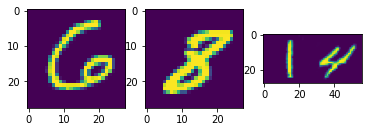

<Figure size 1152x1152 with 0 Axes>

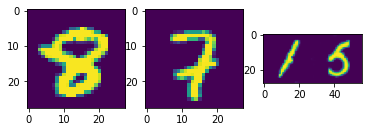

<Figure size 1152x1152 with 0 Axes>

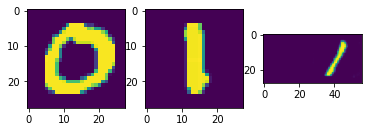

In [164]:
for idx in np.random.randint(0, len(test_set), 3):
    adder.add(test_set, idx, plot=True)

### Multi Addition

In [135]:
test_set_2 = addition(2, "test")
test_set_3 = addition(3, "test")
test_set_4 = addition(4, "test")
test_set_5 = addition(5, "test")

<Figure size 1152x1152 with 0 Axes>

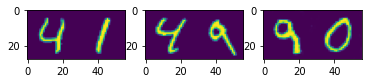

In [145]:
adder.add(test_set_2, 1, True)

<Figure size 1152x1152 with 0 Axes>

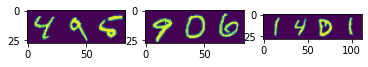

In [146]:
adder.add(test_set_3, 1, True)

<Figure size 1152x1152 with 0 Axes>

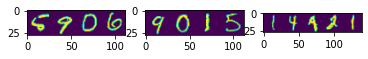

In [147]:
adder.add(test_set_4, 1, True)

<Figure size 1152x1152 with 0 Axes>

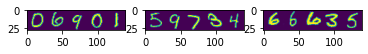

In [148]:
adder.add(test_set_5, 1, True)

## End-to-end

In [1]:
import collections
import sys

import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
# config
latent_dim = 100
batch_size = 64
#img_shape = (1, 56, 56)
lr = 0.0002
n_epochs = 100
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
b1 = 0.5
b2 = 0.999

### Data

In [3]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(
    root="/tmp",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]
    ),
    download = True
)
mnist_test = datasets.MNIST(
    root="/tmp",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]
    ),
    download = True
)

In [4]:
class AddDataset(Dataset):
    def __init__(self, x, y, is_train):
        self.x = torch.stack([torch.stack(i) for i in x]).to(device)
        self.y = np.array(y)
        self.is_train = is_train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.x[idx], self.y[idx]

    def plot(self, idx):
        if self.is_train:
            fig, ax = plt.subplots(1, 3)
            ax[2].imshow(self.y[idx].squeeze())
        else:
            fig, ax = plt.subplots(1, 2)
        ax[0].imshow(self.x[idx][0].detach().cpu().squeeze())
        ax[1].imshow(self.x[idx][1].detach().cpu().squeeze())
        plt.show()
        if not self.is_train:
            print(self.y[idx])

def create_dataset(original, is_train=True):
    x_img = []
    y_num = []
    digits = collections.defaultdict(list)
    for i, (x, y) in enumerate(original):
        if i % 2 == 0:
            x_img.append([x])
            y_num.append(y)
        else:
            x_img[-1].append(x)
            y_num[-1] += y
        if is_train:
            digits[y].append(x)
    if is_train:
        y_img = []
        border_top_bottom = torch.full((1, 14, 56), -1, dtype=torch.float32)
        border_side = torch.full((1, 28, 14), -1, dtype=torch.float32)
        for i in map(str, y_num):
            if len(i) == 1:
                img = digits[int(i)][np.random.randint(len(digits[int(i)]))]
                img = torch.cat([border_side, img, border_side], axis=-1)
            else:
                img1 = digits[int(i[0])][np.random.randint(len(digits[int(i[0])]))]
                img2 = digits[int(i[1])][np.random.randint(len(digits[int(i[1])]))]
                img = torch.cat([img1, img2], axis=-1)
            img = torch.cat([border_top_bottom, img, border_top_bottom], axis=1)
            y_img.append(img)
        return AddDataset(x_img, y_img, is_train)
    return AddDataset(x_img, y_num, is_train)

In [5]:
train_data = create_dataset(mnist_train, is_train=True)
test_data = create_dataset(mnist_test, is_train=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [6]:
dataloader = DataLoader(train_data, batch_size)

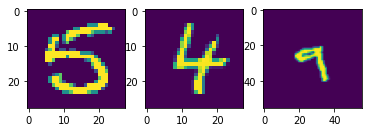

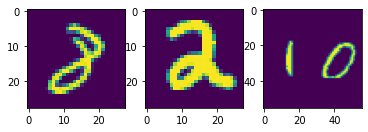

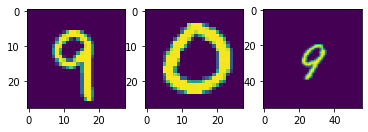

In [7]:
for i in np.random.randint(0, len(train_data), 3):
    train_data.plot(i)

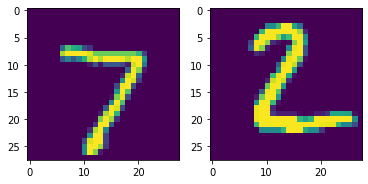

9


In [8]:
test_data.plot(0)

### Model

In [9]:
from torch import nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        #self.image_encoding = nn.Sequential(
        #    nn.Flatten(),
        #    nn.Linear(2*28**2, 7*7*64),
        #    nn.ReLU(inplace=True)
        #)

        self.image_encoding = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 64*7*7),
            nn.ReLU(inplace=True)
        )

        #self.latent = nn.Sequential(
        #    nn.Linear(latent_dim, 7*7*64),
        #    nn.ReLU(inplace=True)
        #)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    #def forward(self, noise, cond_imgs):
    def forward(self, cond_imgs):
        #noise = self.latent(noise).view(noise.shape[0], 64, 7, 7)
        #img_enc = self.image_encoding(cond_imgs.squeeze()).view(noise.shape[0], 1, 7, 7)
        #gen_input = torch.cat((noise, img_enc), dim=1)
        gen_input = self.image_encoding(cond_imgs.squeeze()).view(cond_imgs.shape[0], 64, 7, 7)
        # generate image
        img = self.model(gen_input)
        img = img.view(cond_imgs.shape[0], 1, 56, 56)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.image_encoding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2*28**2, 56**2)
        )

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, img, cond_imgs):
        img_enc = self.image_encoding(cond_imgs).view(img.shape[0], 1, 56, 56)
        d_in = torch.cat((img, img_enc), dim=1)
        # predict validity
        validity = self.model(d_in)
        return validity

## Training

In [10]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Train progress:   0%|          | 0/100 [00:20<?, ?it/s, g-loss=7.9, d-loss=0.000401]

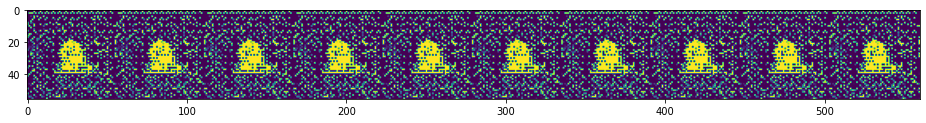

Train progress:  10%|█         | 10/100 [03:38<29:38, 19.77s/it, g-loss=3.56, d-loss=0.149]

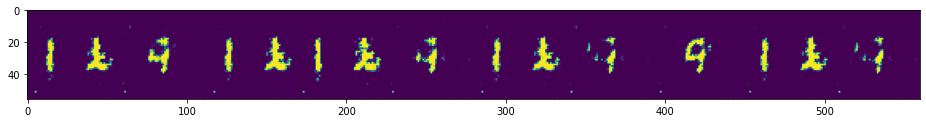

Train progress:  20%|██        | 20/100 [06:55<26:17, 19.72s/it, g-loss=2, d-loss=0.255]   

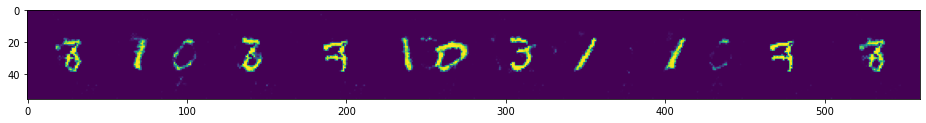

Train progress:  30%|███       | 30/100 [10:13<23:00, 19.72s/it, g-loss=2.77, d-loss=0.139]

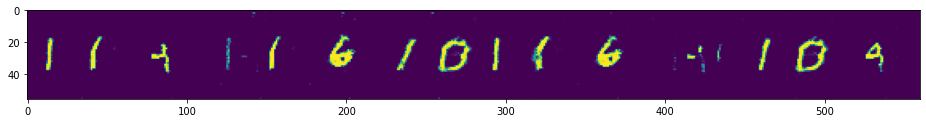

Train progress:  40%|████      | 40/100 [13:30<19:43, 19.73s/it, g-loss=3.4, d-loss=0.0518]

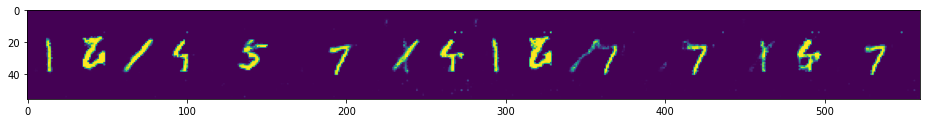

Train progress:  50%|█████     | 50/100 [16:48<16:26, 19.73s/it, g-loss=3.19, d-loss=0.0856]

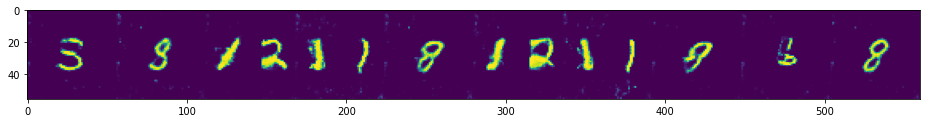

Train progress:  60%|██████    | 60/100 [20:05<13:08, 19.72s/it, g-loss=7.2, d-loss=0.00231] 

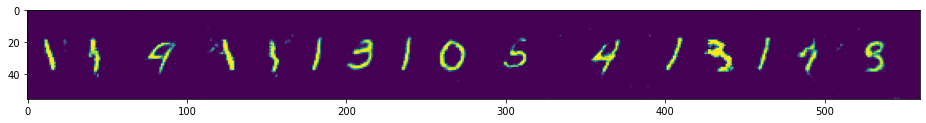

Train progress:  70%|███████   | 70/100 [23:22<09:51, 19.72s/it, g-loss=2.27, d-loss=0.0977]

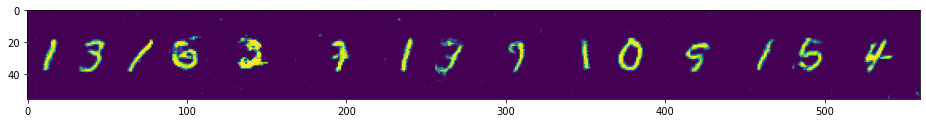

Train progress:  80%|████████  | 80/100 [26:40<06:34, 19.72s/it, g-loss=8.1, d-loss=0.000635]

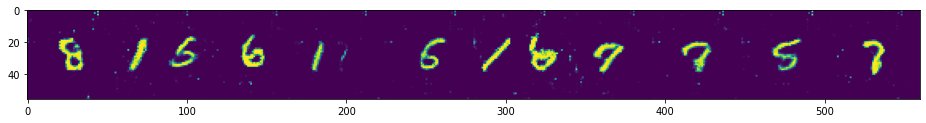

Train progress:  90%|█████████ | 90/100 [29:57<03:17, 19.72s/it, g-loss=7.52, d-loss=0.000527]

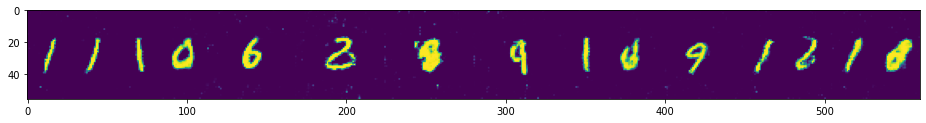

Train progress: 100%|██████████| 100/100 [32:55<00:00, 19.75s/it, g-loss=8.62, d-loss=0.00037]


In [12]:
d_losses, g_losses = [], []
test_size = len(test_data)
train_size = len(train_data)
pbar = tqdm.tqdm(range(n_epochs), desc="Train progress", file=sys.stdout)
for epoch in pbar:
    for i, (cond_imgs, img) in enumerate(dataloader):
        iter_bs = img.shape[0]

        real_img = img.to(device)
        cond_imgs = cond_imgs.to(device).unsqueeze(1)

        # adversarial ground truth
        valid = torch.ones(iter_bs, 1, requires_grad=False, device=device)
        fake = torch.zeros(iter_bs, 1, requires_grad=False, device=device)

        # train generator
        g_optimizer.zero_grad()
        # sample noise
        #z = torch.randn(iter_bs, latent_dim, device=device)
        # sample conditional images for gen
        gen_cond_img = train_data[torch.randint(0, train_size, size=(iter_bs, 1), device=device)][0]

        # generate images
        #gen_imgs = generator(z, gen_cond_img)
        gen_imgs = generator(gen_cond_img)
        
        # generator loss
        validity = discriminator(gen_imgs, gen_cond_img)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        g_optimizer.step()

        # train discriminator
        d_optimizer.zero_grad()
        # loss for real images
        validity_real = discriminator(real_img, cond_imgs)
        d_real_loss = adversarial_loss(validity_real, valid)
        # loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_cond_img)
        d_fake_loss = adversarial_loss(validity_fake, fake)
        # total loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    pbar.set_postfix({"g-loss": g_losses[-1], "d-loss": d_losses[-1]})

    if epoch%10 == 0:
        with torch.no_grad():
            #z = torch.randn(10, latent_dim, device=device)
            idx = torch.randint(0, test_size, (10, ), device=device)
            #gen_imgs = generator(z, test_data[idx][0])
            gen_imgs = generator(test_data[idx][0])
            plt.figure(figsize=(16, 16))
            plt.imshow(np.concatenate(gen_imgs.squeeze().cpu().detach().numpy(), axis=1))
            plt.show()

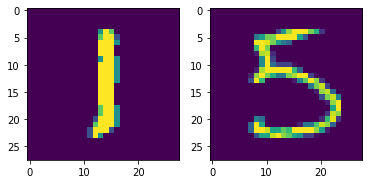

6


In [49]:
i = 7
test_data.plot(i)

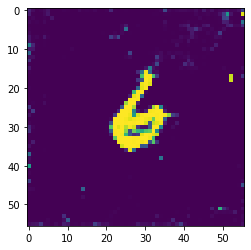

In [50]:
with torch.no_grad():
    #z = torch.randn(1, latent_dim, device=device)
    gen_img = generator(test_data[[i, i+1]][0])
    plt.imshow(gen_img[0].squeeze().cpu().detach().numpy())
    plt.show()